In [29]:
b = responses.cpu().numpy().flatten()
a = out.transpose(1,2).detach().cpu().numpy().flatten()
plt.scatter(a,b, s=3, c="k", alpha=.1)
print(np.corrcoef(a,b))

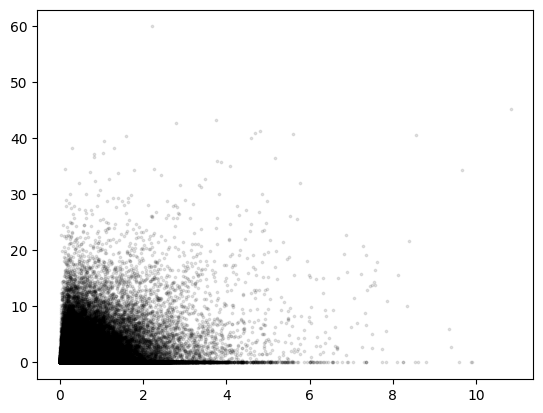

In [31]:
np.corrcoef(a,b)

array([[1.        , 0.29156314],
       [0.29156314, 1.        ]])

In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from os import path

from torch import nn
from torch.nn import functional as F
from torch.nn.functional import scaled_dot_product_attention
from torch.nn.attention import SDPBackend, sdpa_kernel
from tqdm import tqdm
from einops import rearrange
from torch.optim import AdamW, Adam

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from omegaconf import OmegaConf, open_dict
from experanto.datasets import ChunkDataset, SimpleChunkedDataset
from experanto.utils import LongCycler, MultiEpochsDataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# additional packages
# pip install hiera-transformer
# pip install -U pytorch_warmup

# Hyperparameters

In [3]:
video_size = [36, 64]

screen_chunk_size = 16
screen_fs = 16
chunk_size = 8

behavior_as_channels = True
replace_nans_with_means = True

dim_head = 16
num_heads = 6
drop_path_rate = 0
mlp_ratio=4

### get dataloaders

In [4]:
from experanto.dataloaders import get_multisession_dataloader

from experanto.configs import DEFAULT_CONFIG as cfg
paths = ['dynamic29513-3-5-Video-full',
         'dynamic29514-2-9-Video-full',
         'dynamic29755-2-8-Video-full',
         'dynamic29647-19-8-Video-full',
         'dynamic29156-11-10-Video-full',
         'dynamic29623-4-9-Video-full',
         'dynamic29515-10-12-Video-full',
         'dynamic29234-6-9-Video-full',
         'dynamic29712-5-9-Video-full',
         'dynamic29228-2-10-Video-full'
        ]
full_paths = [path.join("/data/mouse_polly/", f) for f in paths]

In [5]:
with open_dict(cfg):
    cfg.dataset.add_behavior_as_channels = behavior_as_channels
    cfg.dataset.replace_nans_with_means = replace_nans_with_means
cfg.dataset.global_chunk_size = None
cfg.dataset.global_sampling_rate = None

cfg.dataset.modality_config.screen.chunk_size = screen_chunk_size
cfg.dataset.modality_config.screen.sampling_rate = screen_fs
cfg.dataset.modality_config.responses.chunk_size = chunk_size
cfg.dataset.modality_config.responses.sampling_rate = 8
cfg.dataset.modality_config.eye_tracker.chunk_size = screen_chunk_size
cfg.dataset.modality_config.eye_tracker.sampling_rate = screen_fs
cfg.dataset.modality_config.treadmill.chunk_size = screen_chunk_size
cfg.dataset.modality_config.treadmill.sampling_rate = screen_fs

cfg.dataset.modality_config.screen.sample_stride = 1
cfg.dataset.modality_config.screen.include_blanks=True
cfg.dataset.modality_config.screen.valid_condition = {"tier": "train"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size

cfg.dataloader.num_workers=1
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=16
cfg.dataloader.pin_memory=True
cfg.dataloader.shuffle=True

train_dl = get_multisession_dataloader(full_paths, cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


### get Hiera backbone

In [6]:
# pip install hiera-transformer
from hiera import Hiera
tiny_hiera = Hiera(input_size=(screen_chunk_size, video_size[0], video_size[1]),
                     num_heads=2,
                     embed_dim=64,
                     stages=(1, 1,), # 4 transformer layers 
                     q_pool=1, 
                     in_chans=6,
                     q_stride=(1, 1, 1,),
                     mask_unit_size=(1, 8, 8),
                     patch_kernel=(3, 9, 9),
                     patch_stride=(1, 4, 4),
                     patch_padding=(1, 3, 3),
                     sep_pos_embed=True,
                     drop_path_rate=drop_path_rate,
                     mlp_ratio=4,)

tiny_hiera = tiny_hiera.cuda().to(torch.float32);
example_input = torch.ones(8,6,screen_chunk_size, 36,64).to("cuda", torch.float32)
out = tiny_hiera(example_input, return_intermediates=True);
hiera_output = out[-1][-1]
hiera_output.shape # (b, t, h, w, c): (8, 4, 9, 16, 192)


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([8, 16, 9, 16, 128])

# Model definition

In [7]:
class MouseHieraBase(nn.Module):
    def __init__(self,
                 backbone,
                 dls,
                 chunk_size,
                 dim=192,
                 dim_head=32,
                 num_heads=4,
                 mlp_ratio=4,):
        super().__init__()
        self.backbone=backbone
        self.num_heads=num_heads
        self.dim_head=dim_head
        self.dim=dim
        self.dim_q = dim_head*num_heads
        self.wq = nn.Linear(self.dim_q, self.dim_q, bias=False)
        self.wk = nn.Linear(dim, self.dim_q, bias=False)
        self.wv = nn.Linear(dim, self.dim_q, bias=False)
        self.wo = nn.Linear(self.dim_q, self.dim_q, bias=False)
        
        self.neuron_proj = nn.Linear(self.dim_q, chunk_size, bias=False)
        
        
        self.kv_norm=torch.nn.RMSNorm(dim)
        self.q_norm=torch.nn.RMSNorm(self.dim_q)
        self.qkv_norm=torch.nn.RMSNorm(self.dim_q)
        self.mlp = MLP(dim=self.dim_q, hidden_dim=int(self.dim_q * mlp_ratio))
        self.readout = nn.ModuleDict()
        self.activation = nn.Softplus(beta=0.1) # probably a much better activation than ELU+1
        for k, v in dls.loaders.items():
            n_neurons = next(iter(v))["responses"].shape[-1]
            self.readout[k] = IndexedLinearReadout(n_neurons, 
                                                   in_features=dim_head*num_heads,
                                                   dim_head=dim_head, 
                                                   num_heads=num_heads, 
                                                  )
        self.init_weights()

    def forward(self, x, key):
        x = self.backbone(x, return_intermediates=True)[-1][-1]
        b, t, h, w, d = x.shape
        x = self.kv_norm(x)
        x = x.view(b, -1, d) # (B, t*h*w, D)
        k, v = self.wk(x), self.wv(x)
        q = self.q_norm(self.readout[key].query)
        n = q.shape[1] # number of neurons
        q = q.repeat(b, 1, 1) # repeat query for number of batches
        q_attn = self.wq(q)
        q_attn = q_attn.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2)
        k = k.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        v = v.view(b, -1, self.num_heads, self.dim_head).transpose(1, 2) # (B, H, S, D)
        with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
            o = F.scaled_dot_product_attention(q_attn, k, v)
        # (B, H, S, D) -> (B, N, D), with N = num_neurons
        o = o.transpose(1,2).contiguous().view(b, -1, self.dim_q)
        o = self.wo(o) + q
        o = self.qkv_norm(o)  
        o = self.mlp(o) + o
        o = self.neuron_proj(o) # (B, N, D) -> (B, N, t)
        o = o + self.readout[key].bias
        o = self.activation(o)
        return o
     
    def init_weights(self, std=.5, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        std = self.dim_q**-0.5
        for lin in (self.wq, self.wk, self.wv, self.wo):
            nn.init.trunc_normal_(
                lin.weight,
                mean=0.0,
                std=std,
                a=-cutoff_factor * std,
                b=cutoff_factor * std,
            )

In [8]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )
        self.init_weights()

    def forward(self, x):
        return self.net(x)
        
    def init_weights(self, std=.5, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        nn.init.trunc_normal_(
            self.net[0].weight,
            mean=0.0,
            std=std,
            a=-cutoff_factor * std,
            b=cutoff_factor * std,
        )
        nn.init.trunc_normal_(
            self.net[2].weight,
            mean=0.0,
            std=std,
            a=-cutoff_factor * std,
            b=cutoff_factor * std,
        )
        self.net[0].bias.data.zero_()
        self.net[2].bias.data.zero_()
        

In [9]:
class IndexedLinearReadout(nn.Module):
    """
    Readout module for MTM models with selectable weights based on 
    input IDs. Based on :class:`torch.nn.Linear`.
    """
    def __init__(
        self,
        unique_ids: int,
        in_features: int = 384,
        dim_head=32,
        num_heads=4,
        bias: bool = True,
        device="cuda",
        dtype=torch.float32,
        init_std: float = 0.02,
    ):
        super().__init__()
        factory_kwargs = {"device": device, "dtype": dtype}
        self.unique_ids = unique_ids
        self.in_features = in_features
        self.init_std = init_std
        self.query = nn.Parameter(
            torch.empty(1, unique_ids, dim_head*num_heads, **factory_kwargs)
        )
        if bias:
            self.bias = nn.Parameter(
                torch.empty(1, unique_ids, 1, **factory_kwargs)
            )
        else:
            self.register_parameter('bias', None)
        self.init_weights()

    def init_weights(self, cutoff_factor: int = 3):
        """See `TorchTitan <https://github.com/pytorch/torchtitan/blob/40a10263c5b3468ffa53b3ac98d80c9267d68155/torchtitan/models/llama/model.py#L403>`__."""
        readout_std = self.in_features**-0.5
        nn.init.trunc_normal_(
            self.query,
            mean=0.0,
            std=readout_std,
            a=-cutoff_factor * readout_std,
            b=cutoff_factor * readout_std,
        )
        if self.bias is not None:
            self.bias.data.zero_()

### Build Model

In [10]:
backbone_dim = hiera_output[-1][-1].shape[-1]
model = MouseHieraBase(backbone=tiny_hiera, 
                        dls=train_dl, 
                        chunk_size=chunk_size,
                        dim=backbone_dim, 
                        dim_head=dim_head,
                        num_heads=num_heads,
                       mlp_ratio=mlp_ratio)

### performance boosts

In [11]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision('high')

torch._dynamo.config.cache_size_limit = 32
model = model.cuda().to(torch.float32)

# Trainer

In [12]:
# pip install -U pytorch_warmup
import pytorch_warmup as warmup

lr = 3e-4
T_max = 2e6
eta_min = 5e-6

criteria = nn.PoissonNLLLoss(log_input=False, reduction='mean')
opt = Adam(model.parameters(), lr=lr, )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,
                                                          T_max=T_max, 
                                                          eta_min=eta_min)

warmup_scheduler = warmup.UntunedLinearWarmup(opt)

from torch import autocast, GradScaler

# Logging

In [13]:
import os
import sys
from omegaconf import DictConfig, ListConfig

import hydra
from hydra import utils
import mlflow
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import mlflow
mlflow.set_tracking_uri("http://at-compute015:5000/")


In [14]:
experiment_name = "mousehiera-base-0"
current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id=current_experiment['experiment_id']

# train messy

In [15]:
from experanto.configs import DEFAULT_CONFIG as cfg

with open_dict(cfg):
    cfg.dataset.add_behavior_as_channels = behavior_as_channels
    cfg.dataset.replace_nans_with_means = replace_nans_with_means
cfg.dataset.global_chunk_size = None
cfg.dataset.global_sampling_rate = None

cfg.dataset.modality_config.screen.chunk_size = screen_chunk_size
cfg.dataset.modality_config.screen.sampling_rate = screen_fs
cfg.dataset.modality_config.responses.chunk_size = chunk_size
cfg.dataset.modality_config.responses.sampling_rate = 8
cfg.dataset.modality_config.eye_tracker.chunk_size = screen_chunk_size
cfg.dataset.modality_config.eye_tracker.sampling_rate = screen_fs
cfg.dataset.modality_config.treadmill.chunk_size = screen_chunk_size
cfg.dataset.modality_config.treadmill.sampling_rate = screen_fs

cfg.dataset.modality_config.screen.sample_stride=screen_chunk_size
cfg.dataset.modality_config.screen.valid_condition = {"tier": "oracle"}
cfg.dataset.modality_config.screen.transforms.Resize.size = video_size


cfg.dataloader.num_workers=1
cfg.dataloader.prefetch_factor=1
cfg.dataloader.batch_size=128
cfg.dataloader.pin_memory=True
# the multiple dataloader is an iterator that returns a tuple of (key, batch)
val_dl = get_multisession_dataloader(full_paths[3:6], cfg)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [16]:
def val_step_():
    targets, predictions = [],[]
    with torch.no_grad():
        for i, (k, b) in tqdm(enumerate(val_dl)):
            videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                out = model(videos, k);
            predictions.append(out.transpose(1,2).flatten())
            targets.append(responses.flatten())
        c = np.corrcoef(torch.hstack(predictions).cpu().numpy(), torch.hstack(targets).cpu().numpy(), )
    return c[0,1]

In [ ]:
patience = 0
max_objective = 0
losses, corrs, lrs, val_corrs = [], [], [], []
with mlflow.start_run(
    run_name="behavior_long_6",
    experiment_id=experiment_id,
    tags={"version": "v1", "priority": "P1"},
    description="parent",):
    
    for train_loop in range(1000):
        model.eval();
        current_objective = val_step_()
        mlflow.log_metric("val/single_trial_corr", current_objective)
        if train_loop > 20:
            max_objective = np.max(np.array(val_corrs[:-1])[~np.isnan(val_corrs[:-1])])
        if current_objective < max_objective:
            patience += 1
        else:
            patience = 0
        if patience >3:
            break
        val_corrs.append(current_objective)
        print(val_corrs)
        for i, (k, b) in tqdm(enumerate(train_dl)):
            model.train();
            videos = b["screen"].to("cuda", torch.float32, non_blocking=True).permute(0,2,1,3,4)
            responses = b["responses"].to("cuda", torch.float32, non_blocking=True)
            with autocast(device_type='cuda', dtype=torch.bfloat16):
                out = model(videos, k);
            loss = criteria(out.transpose(1,2), responses)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
            opt.step()
            opt.zero_grad()
            
            with warmup_scheduler.dampening():
                lr_scheduler.step()
        for k, v in train_dl.loaders.items():
            v.dataset.shuffle_valid_screen_times()

12it [00:12,  1.08s/it]


[np.float64(0.0005121589150979053)]


2569it [02:22, 16.90it/s]